# L'objectif de ce notebook est de créer les fonctions necessaires à la pipeline globale de detection marque et modèle
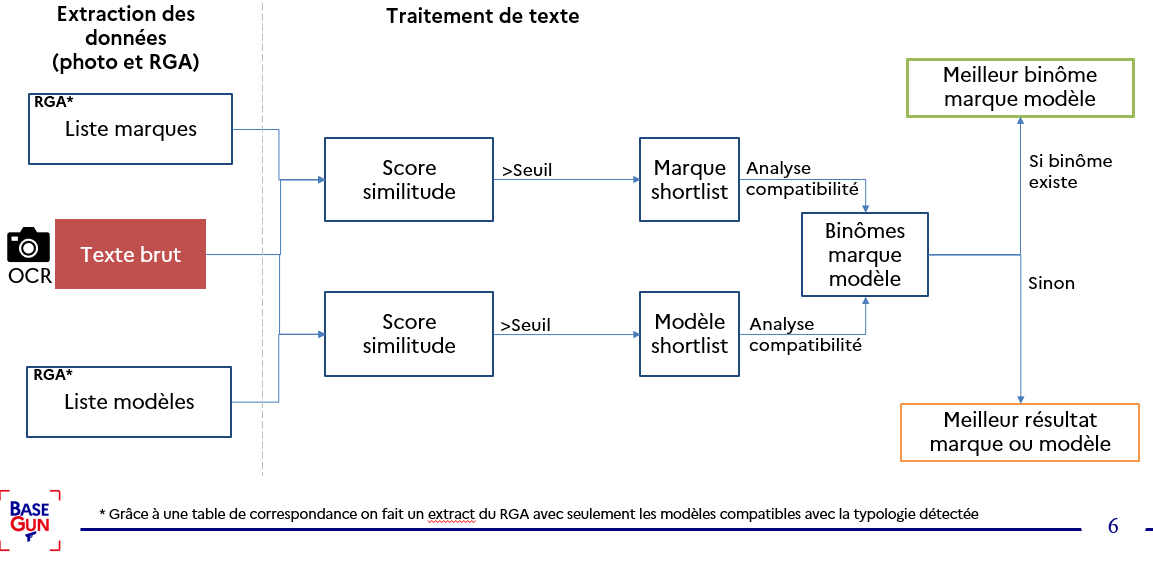

In [37]:
import requests
import json
import time
import pandas as pd
import io 
from datetime import datetime
import json
from rapidfuzz import fuzz

with open('BasegunRGA.json') as f:
    BasegunRGA = json.load(f)

## Récupération dynamique du RGA

In [42]:
#Initialization
#request RGA dataset on datagouv
RGA=pd.DataFrame({})
date_format = '%Y-%m-%d'
last_update=datetime.strptime('2012-11-14',date_format)

def updateRGA():
    r = requests.get('https://www.data.gouv.fr/api/1/datasets/6102b1edf18aee6cdd571427/')
    RGAJSON=json.loads(r.text)
    date_str=RGAJSON['resources'][0]['created_at'].split('T')[0]
    date_format = '%Y-%m-%d'
    last_update=datetime.strptime(date_str, date_format)
    latestRGA=RGAJSON['resources'][0]['latest']
    r = requests.get(latestRGA, allow_redirects=True)
    df=pd.read_csv(io.StringIO(r.content.decode('windows-1252')),encoding='unicode_escape',on_bad_lines='skip', sep=';')
    df= df.fillna('')
    return df, last_update

In [43]:
RGA,last_update=updateRGA()

## Filtrage du RGA selon la typologie
Input : RGA et typologie Basegun
Output : RGA filtré avec les règles de gestion définies par les experts

Il faudrait stocker les règles de gestion dans un fichier séparé de façon à ne pas surcharger le code et pour pouvoir les modifier plus facilement

In [29]:
def filterRGA(RGA,typologie):
    rules=BasegunRGA[typologie]
    keys=list(rules.keys())
    for key in keys:
        RGA=RGA[RGA[key].isin(rules[key])]
    return RGA

In [31]:
filterRGA(RGA,"revolver")

,referenceRGA,famille,typeArme,marque,modele,fabricant,paysFabricant,modeFonctionnement,systemeAlimentation,longueurArme,...,typeCanonQuatre,longueurCanonQuatre,armeSemiAutoApparenceArmeAuto,designation_commerciale,classementFrancais,classementEuropeen,prototype,visible,dateCreaRGA,dateMajRGA
30,BK279,POING,REVOLVER,TAURUS,"MOD 627 ""TRACKER""",TAURUS,BRESIL,A REPETITION MANUELLE,BARILLET,227,...,NaN,NaN,non,NaN,B 1°,B,non,oui,23/01/2020,23/01/2020
56,BU963,POING,REVOLVER,HARPAX,INSPECTOR,UBERTI (ALDO),ITALIE,A REPETITION MANUELLE,BARILLET,188,...,NaN,NaN,non,CAT. 4001,B 1°,B,non,oui,15/07/2021,15/07/2021
82,BJ778,POING,REVOLVER,SMITH & WESSON,"MOD 686 ""PLUS""",SMITH & WESSON,ETATS-UNIS,A REPETITION MANUELLE,BARILLET,312,...,NaN,NaN,non,NaN,B 1°,B,non,oui,28/11/2019,28/11/2019
83,BJ781,POING,REVOLVER,SMITH & WESSON,"MOD 64 ""MILITARY & POLICE""",SMITH & WESSON,ETATS-UNIS,A REPETITION MANUELLE,BARILLET,226,...,NaN,NaN,non,NaN,B 1°,B,non,oui,28/11/2019,28/11/2019
91,BK602,POING,REVOLVER,COLT,"OFFICER'S ""SPECIAL""",COLT MANUFACTURING COMPANY LLC,ETATS-UNIS,A REPETITION MANUELLE,BARILLET,300,...,NaN,NaN,non,OFFICER MODEL SPECIAL,B 1°,B,non,oui,13/02/2020,13/02/2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58768,CG835,POING,REVOLVER,ALFA-PROJ,MODEL 030,ALFA-PROJ,TCHEQUE (REPUBLIQUE),A REPETITION MANUELLE,BARILLET,201,...,NaN,NaN,non,HOMOLOGUE DE,C 12°,-,non,oui,04/07/2024,04/07/2024
58769,CG836,POING,REVOLVER,ALFA-PROJ,MODEL 030,ALFA-PROJ,TCHEQUE (REPUBLIQUE),A REPETITION MANUELLE,BARILLET,176,...,NaN,NaN,non,HOMOLOGUE DE,C 12°,-,non,oui,04/07/2024,04/07/2024
58770,CG837,POING,REVOLVER,ALFA-PROJ,MODEL 030,ALFA-PROJ,TCHEQUE (REPUBLIQUE),A REPETITION MANUELLE,BARILLET,226,...,NaN,NaN,non,HOMOLOGUE DE,C 12°,-,non,oui,04/07/2024,04/07/2024
58799,CG877,POING,REVOLVER,IVER JOHNSON,SAA MOD 1873,UBERTI (ALDO),ITALIE,A REPETITION MANUELLE,BARILLET,320,...,NaN,NaN,non,NaN,B 1°,B,non,oui,09/07/2024,09/07/2024


## Calculs de similitude et analyse de compatibilité
Les fonctions de similitudes prennent en entrée le RGA filtré et le texte brut issu de l'OCR et renvoient en sortie les marques ou modèles dépassants le seuil.

Des expérimentations sur les métriques sont à prévoir avec un dataset plus conséquent

In [151]:
THRESHOLDBrand=30
THRESHOLDModel=50
text="ZoRaKL M 906 -TD"

def brand_matching(RGA,text): 
    brands=list(RGA["marque"])
    brands2=list(dict.fromkeys(brands)) #remove duplicates
    brandsim={}
    for brand in brands2:
        sim=fuzz.token_set_ratio(brand.lower(), text.lower())
        if sim>THRESHOLDBrand:
            brandsim[brand]=sim
    brandsim=dict(sorted(brandsim.items(),key=lambda x: x[1],reverse=True))
    return brandsim

def model_matching(RGA,text): 
    models=list(RGA["modele"])
    models2=list(dict.fromkeys(models)) #remove duplicates
    modelsim={}
    for model in models2:
        sim=fuzz.token_set_ratio(model.lower(), text.lower())
        if sim>THRESHOLDModel:
            modelsim[model]=sim
    modelsim=dict(sorted(modelsim.items(),key=lambda x: x[1],reverse=True))
    return modelsim

In [152]:
modelSim=model_matching(RGA,text)
brandSim=brand_matching(RGA,text)

## Analyse de compatibilité
La fonction prend en entrée les shortlists de marques et modèles et le RGA filtré et les croise pour voir si il ya une compatibilité et renvoit les lignes du RGA compatibles, sinon **à arbitrer**

Si plusieurs modèles/marques on renvoit la meilleure note cummulée

In [154]:
def compatibility(brandSim,modelSim,RGA):
    models=list(modelSim.keys())
    brands=list(brandSim.keys())
    RGAModel=RGA[RGA["modele"].isin(models) & RGA["marque"].isin(brands)]
    if len(RGAModel)<1:
        return (brands,models)
    else :
        return RGAModel

In [156]:
compatibility(brandSim,modelSim,RGA)

,referenceRGA,famille,typeArme,marque,modele,fabricant,paysFabricant,modeFonctionnement,systemeAlimentation,longueurArme,...,typeCanonQuatre,longueurCanonQuatre,armeSemiAutoApparenceArmeAuto,designation_commerciale,classementFrancais,classementEuropeen,prototype,visible,dateCreaRGA,dateMajRGA
58640,CG686,POING,PISTOLET,ZORAKI,906,ATAK ARMS LTD,TURQUIE,SEMI-AUTOMATIQUE,CHARGEUR AMOVIBLE,143,...,,,non,HOMOLOGUE FR,C 12°,-,non,oui,28/06/2024,28/06/2024


## Fonction globale